In [1]:
import mlflow
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

Data

In [2]:
data_path = 'Dataset/creditcard.csv'
df = pd.read_csv(data_path)
df = df.drop('Time', axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
normal = df[df.Class == 0].sample(frac = 0.5, random_state = 2022).reset_index(drop = True)
anomaly = df[df.Class == 1]

normal.shape, anomaly.shape

((142158, 30), (492, 30))

In [4]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test =train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [5]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis = 1)
x_test = x_test.drop("Class", axis = 1)
x_validate = x_validate.drop("Class", axis = 1)

Scaling

In [6]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop('Class', axis = 1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

Training with MLFlow

In [7]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric('train_acc', train_acc)
    
    print('Training Accuracy:', train_acc * 100, '%')

In [8]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    
    mlflow.log_metric('eval_acc', eval_acc)
    mlflow.log_metric('auc_score', auc_score)
    
    print('AUC Score:', auc_score)
    print('Eval Accuracy:', eval_acc * 100, '%')
    
    roc_plot = plot_roc_curve(sk_model, x_test, y_test, name = 'ROC Curve')
    plt.savefig('roc_plot.png')
    plt.show()
    plt.clf()
    
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot = True, fmt = 'g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig('conf_matrix.png')
    
    mlflow.log_artifact('roc_plot.png')
    mlflow.log_artifact('conf_matrix.png')

Logging and Viewing MLFlow Runs

In [9]:
sk_model = LogisticRegression(max_iter = 150,
                              n_jobs = -1,
                              solver = 'newton-cg')

Training Accuracy: 99.87848763845399 %
AUC Score: 0.8332102326017632
Eval Accuracy: 99.8598016192913 %


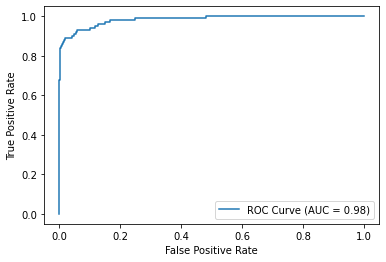

Model run:  2f25f82129f8493897a0f5dfd64e84e4


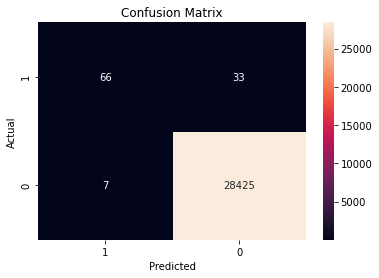

In [10]:
mlflow.set_experiment('scikit_learn_experiment')

with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, 'log_reg_model')
    
    print('Model run: ', mlflow.active_run().info.run_uuid)
    mlflow.end_run()

In [25]:
path = 'runs:/4b418e26647a4656bc839593e43363a5/log_reg_model'
loaded_model = mlflow.sklearn.load_model(path)

In [26]:
loaded_model.score(x_validate, y_validate)

0.9987031649784445

Parameter Tuning

In [11]:
num_folds = 5
anomaly_weights = [1, 5, 10, 15]

kfold = KFold(n_splits = num_folds, shuffle = True, random_state = 2022)

In [13]:
mlflow.set_experiment('parameter_tune_broad_search')
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param('anomaly_weight', weight)
            
            class_weights = {0:1, 1:weight}
            
            sk_model = LogisticRegression(max_iter = 400, n_jobs = -1,
                                         solver = 'newton-cg',
                                         class_weight = class_weights).fit(x_validate[train], y_validate[train])
            
            for h in range(40): print('-', end = "")
            print('Fold', fold, 'Anomaly Weight:', weight)
            
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric('train_acc', train_acc)
            
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric('eval_acc', eval_acc)
            
            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            
            mlflow.log_metric('auc_score', auc_score)
            print('AUC:', auc_score, 'auc_score', auc_score)
            
            accuracies.append(eval_acc)
            accuracies.append(auc_scores)
            
            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            
            fold = fold + 1
            mlflow.end_run()

----------------------------------------Fold 1 Anomaly Weight: 1
AUC: 0.8514997391757956 auc_score 0.8514997391757956
----------------------------------------Fold 2 Anomaly Weight: 1
AUC: 0.8634604311944213 auc_score 0.8634604311944213
----------------------------------------Fold 3 Anomaly Weight: 1
AUC: 0.7726393065063015 auc_score 0.7726393065063015
----------------------------------------Fold 4 Anomaly Weight: 1
AUC: 0.947192581418378 auc_score 0.947192581418378
----------------------------------------Fold 5 Anomaly Weight: 1
AUC: 0.8888011233982798 auc_score 0.8888011233982798
----------------------------------------Fold 1 Anomaly Weight: 5
AUC: 0.9068792383933229 auc_score 0.9068792383933229
----------------------------------------Fold 2 Anomaly Weight: 5
AUC: 0.9314663169342972 auc_score 0.9314663169342972
----------------------------------------Fold 3 Anomaly Weight: 5
AUC: 0.8859238052587806 auc_score 0.8859238052587806
----------------------------------------Fold 4 Anomaly Wei